In [1]:
import os
import lightning.pytorch as L
from pytorch_lightning.loggers import CometLogger
from lightning.pytorch.callbacks import ModelCheckpoint, RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

from utils.configs import ExperimentConfigs
from utils.callbacks import MetricLoggerCallback 
from utils.dataloader import DataloaderModule
from data.particle_clouds.jets import JetDataModule
from multimodal_bridge_matching import MultiModalBridgeMatching


config = ExperimentConfigs('config.yaml')
jets = JetDataModule(config=config, preprocess=True)



/home/df630/Multimodal-Bridges/multimodal_bridges/data/particle_clouds/particles.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.continuous = (self.continuous.clone().detach() - torch.tensor(mean)) / (
/home/df630/Multimodal-Bridges/multimodal_bridges/data/particle_clouds/particles.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(std)


INFO: Storing metadata at: ./metadata.json


In [9]:
# open json file
import json

def get_from_json(key, path, name='metadata.json'):
    path = os.path.join(path, name)
    with open(path, 'r') as f:
        metadata = json.load(f)
    return metadata[key]

stats = get_from_json('target_stats')

jets.target.postprocess(continuous='standardize', discrete='discretize', **stats)

/home/df630/Multimodal-Bridges/multimodal_bridges/data/particle_clouds/particles.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.continuous = (self.continuous * torch.tensor(std)) + torch.tensor(mean)


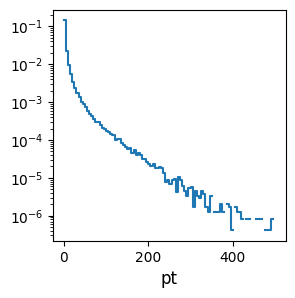

In [15]:
jets.target.histplot('pt', log_scale=(False, True), binwidth=5, binrange=(0, 500), fill=False, stat='density')

In [ ]:
jets.target.histplot('eta_rel', log_scale=(False, True), binwidth=5, binrange=(0, 500), fill=False, stat='density')

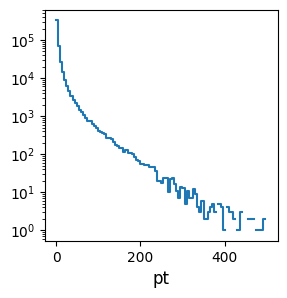

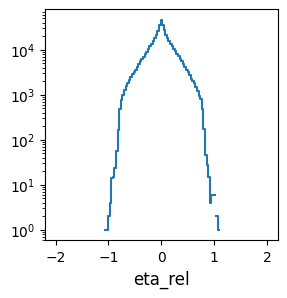

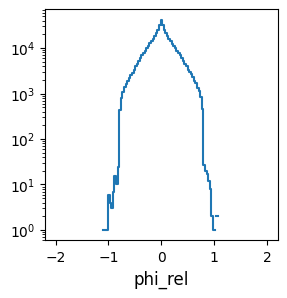

In [17]:
jets.target.histplot(
    feature="pt", fill=False, binrange=(-1, 500), binwidth=5, log_scale=(False, True)
)  # momentum distrbution
jets.target.histplot(
    feature="eta_rel",
    fill=False,
    binrange=(-2, 2),
    binwidth=0.03,
    log_scale=(False, True),
)  # rapidity distribution
jets.target.histplot(
    feature="phi_rel",
    fill=False,
    binrange=(-2, 2),
    binwidth=0.03,
    log_scale=(False, True),
)  # azimuthal angle distribution

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.histplot(
    jets.source.multiplicity.squeeze(-1),
    element="step",
    fill=False,
    discrete=True,
    lw=0.75,
    stat="density",
    log_scale=(False, False),
    ax=ax,
    label="source",
)
sns.histplot(
    jets.target.multiplicity.squeeze(-1),
    element="step",
    fill=False,
    discrete=True,
    lw=0.75,
    stat="density",
    log_scale=(False, False),
    ax=ax,
    color='r',
    label="target",
)
ax.legend(fontsize=6)
ax.set_xlabel("Jet Multiplicity")
plt.show()

In [ ]:
import torch
torch.min(jets.target.pt.squeeze(-1)).item()

In [ ]:

noise = torch.randn_like(jets.target.continuous)
mask = jets.target.mask > 0
jets.target.continuous + noise * ~mask

In [ ]:
X = torch.randint_like(jets.target.mask, 0, 8)
from data.particle_clouds.utils import tokens_to_physics

Y = torch.cat(tokens_to_physics(X), dim=-1)
Y

In [ ]:
jets.target.mask

In [ ]:
jets.target.continuous

In [ ]:

dataloader = DataloaderModule(config=config, datamodule=jets)
model = MultiModalBridgeMatching(config)

In [ ]:
#...Loggers

if hasattr(config.experiment, 'comet_logger'):
    logger = CometLogger(**config.experiment.comet_logger.to_dict())
    config.experiment.comet_logger.experiment_key = logger.experiment.get_key()
    logger.experiment.log_parameters(parameters=config.to_dict())
else:
    logger = None
    
#...Callbacks (always after loading model and data)

progress_bar = RichProgressBar(theme=RichProgressBarTheme(**config.experiment.progress_bar.to_dict()))
checkpoints = ModelCheckpoint(**config.experiment.checkpoints.to_dict())
metrics = MetricLoggerCallback(sync_dist=True)

In [ ]:
#...Train

trainer = L.Trainer(
    max_epochs=config.train.max_epochs,
    accelerator="gpu",
    strategy='ddp_notebook',
    num_nodes=1,
    devices=[0,3],
    sync_batchnorm=True,
    gradient_clip_val=1.0,
    callbacks=[progress_bar, checkpoints, metrics],  # Pass all callbacks
    logger=logger,  # Logger
)

trainer.fit(
        model, train_dataloaders=dataloader.train, val_dataloaders=dataloader.valid
    )